In [1]:
import warnings
import copy
import numpy as np
import heapq
from IPython.display import display, Image


from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.PDBIO import Select
from Bio import SeqIO
from Bio import pairwise2
from Bio.Align import substitution_matrices
BLOSUM62 = substitution_matrices.load('BLOSUM62')

from scipy.linalg import sqrtm

----
To pair residues of both moleculs, local alignment with Smith-Watermann algorithm is used. Pairs are made between corresponding backbone atoms of aligned residues.


## 1. Fetch their structures from pdb

...fetches `.cif`, save as `.pdb` using PyMol.
- https://www.rcsb.org/structure/1ZEH
- https://www.rcsb.org/structure/1LPH

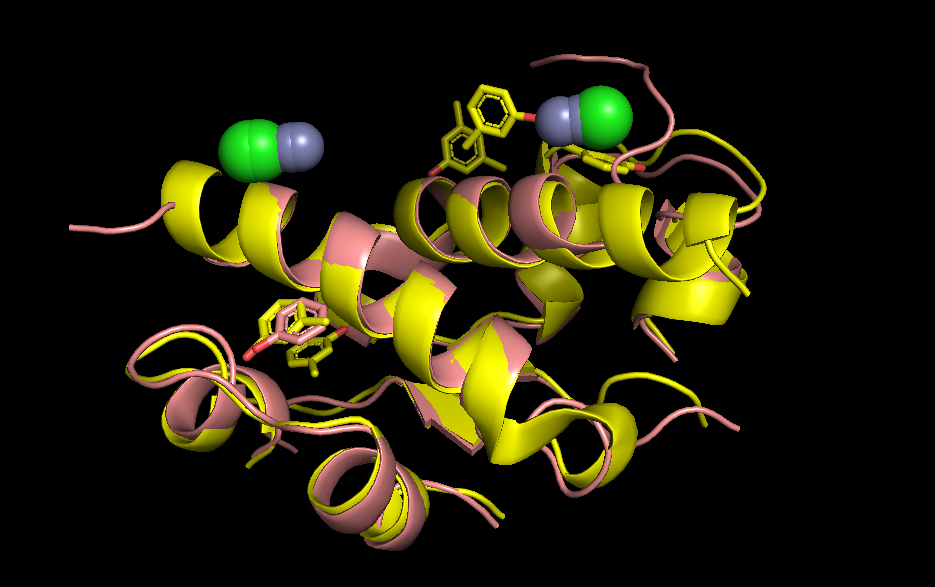

In [2]:
display(Image('img/pymol_view_initial.png'))

(here yellow is Human Insulin, Pink is Insulin LysPro)

## 2. Preprocessing 

The structures already look "aligned", so in order to see results of the algorithms, we will transform one of them. Also, while we are at it, remove Zinc, Cresol and other preservatives, and leave only single chain.

In [3]:
parser = PDBParser(PERMISSIVE=1) # ignore some PDB specification problems

filename = '1lph.pdb'
struct_id = '1lph'
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    struct = parser.get_structure(struct_id, filename)
for res in struct.get_residues():
    print(res.get_id(), end=' ')

(' ', 1, ' ') (' ', 2, ' ') (' ', 3, ' ') (' ', 4, ' ') (' ', 5, ' ') (' ', 6, ' ') (' ', 7, ' ') (' ', 8, ' ') (' ', 9, ' ') (' ', 10, ' ') (' ', 11, ' ') (' ', 12, ' ') (' ', 13, ' ') (' ', 14, ' ') (' ', 15, ' ') (' ', 16, ' ') (' ', 17, ' ') (' ', 18, ' ') (' ', 19, ' ') (' ', 20, ' ') (' ', 21, ' ') (' ', 1, ' ') (' ', 2, ' ') (' ', 3, ' ') (' ', 4, ' ') (' ', 5, ' ') (' ', 6, ' ') (' ', 7, ' ') (' ', 8, ' ') (' ', 9, ' ') (' ', 10, ' ') (' ', 11, ' ') (' ', 12, ' ') (' ', 13, ' ') (' ', 14, ' ') (' ', 15, ' ') (' ', 16, ' ') (' ', 17, ' ') (' ', 18, ' ') (' ', 19, ' ') (' ', 20, ' ') (' ', 21, ' ') (' ', 22, ' ') (' ', 23, ' ') (' ', 24, ' ') (' ', 25, ' ') (' ', 26, ' ') (' ', 27, ' ') (' ', 28, ' ') (' ', 29, ' ') (' ', 30, ' ') ('H_ ZN', 31, ' ') (' ', 1, ' ') (' ', 2, ' ') (' ', 3, ' ') (' ', 4, ' ') (' ', 5, ' ') (' ', 6, ' ') (' ', 7, ' ') (' ', 8, ' ') (' ', 9, ' ') (' ', 10, ' ') (' ', 11, ' ') (' ', 12, ' ') (' ', 13, ' ') (' ', 14, ' ') (' ', 15, ' ') (' ', 16, ' ') (' 

We can see that preservatives have non empty first field in their ID (`H_ CL` etc) and true residues have a string of one space...

In [4]:
class SingleMol_RemovePreservatives(Select):
    def accept_residue(self, res):   # "residue"...
        return res.get_id()[0]  == ' '
    def accept_chain(self, chain):
        return chain.get_id() in 'AB'
    
rot = np.array([[-0.62691553,  0.69367306,  0.35467535],   
        [ 0.77836521,  0.57726208,  0.24681187],
        [-0.03353388,  0.43079715, -0.90182553]])
trans =  np.array([  7.31494657, -28.94659109,   1.9758204 ])
    
ids = ['1lph', '1zeh']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for struct_id in ids:
        filename = struct_id + '.pdb'
        structure = parser.get_structure(struct_id, filename)
        if ids == '1lph':
            structure.transform(rot, trans)

        io_res = PDBIO()
        io_res.set_structure(structure)
        io_res.save(struct_id + '_1m_woP.pdb', SingleMol_RemovePreservatives())

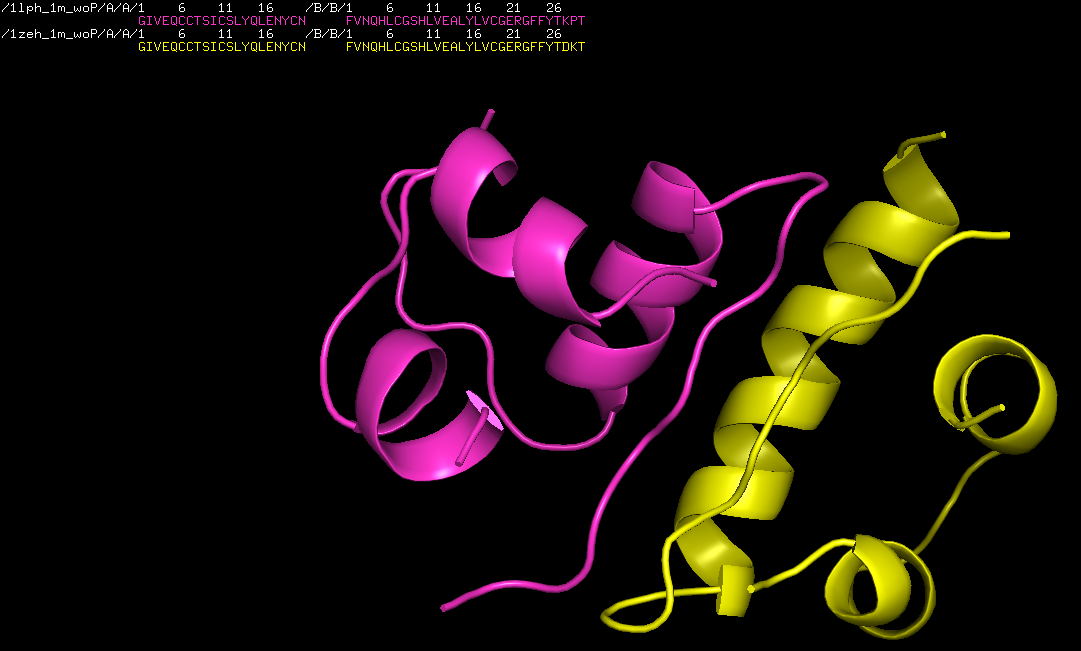

In [5]:
display(Image('img/pymol_view_1m_unaligned.png'))

## 3. Implementation (RMSD included)

In [8]:
def read_pdb(files):
    """
        Parses 2 pdb files, returning list of structures and 
        list of lists of sequences in each structre
    """
    assert len(files) == 2
    
    parser = PDBParser(PERMISSIVE=1) # ignore some PDB specification problems
    structures = []
    sequences = []
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for file in files:
            s_id = file.strip('.pdb')
            structures.append(parser.get_structure(s_id, file))
            
            # there might be several chains in a structures that we wish to align 
            # as is the case with insulins...
            with open(file, 'r') as handle:   
                sequences.append([str(s.seq) for s in SeqIO.parse(handle, "pdb-atom")])
                
    assert len(sequences[0]) == len(sequences[1]), "Structures must have the same number of chains"
    return structures, sequences
    
    
def align(sequences):
    """
        Runs local alignment with BLOSUM matrix for each pair of sequnces
    """
    seq1, seq2 = sequences
    
    #  we will just assume that the relevant chains are in the same order in both structures
    N = len(seq1)
    alignments = []
    for i in range(N):
        a = pairwise2.align.localdx(seq1[i], seq2[i], BLOSUM62)[0]
        alignments.append(a)
    return alignments


def constructPQ(structures, alignments, debug=False):
    """
        Computes vectors P, Q using alignments for pairing
    """
    s1, s2 = structures
    
    chains1 = list(s1.get_chains())
    chains2 = list(s2.get_chains())
    n_chains = len(chains1)
    
    P = []
    Q = []

    if debug:
        print('Pairing:')
    for i in range(n_chains):  # for each chain 
        seq1, seq2 = alignments[i][:2]
        if debug:
            print('=' * 10, seq1, seq2, sep='\n')
        al_length = len(seq1)
        ch1, ch2 = chains1[i], chains2[i]
        iter_res1 = ch1.get_residues()
        iter_res2 = ch2.get_residues()

        res1 = next(iter_res1)
        res2 = next(iter_res2)
        for j in range(al_length):  # for each position in an alignment of said chain...
            if seq1[j] != '-' and seq2[j] != '-':   # if both residues are present in sequence alignment 
                atms1 = list(res1.get_atoms())      # then they will also be present in structural alignment
                atms2 = list(res2.get_atoms())
                if debug:
                    print(res1.get_resname(), res2.get_resname())
                for k in range(3):   # add backbone atoms
                    P.append(atms1[k].get_coord())
                    Q.append(atms2[k].get_coord())
                if j != al_length - 1:
                    res1 = next(iter_res1)
                    res2 = next(iter_res2)
            elif seq1[j] == '-':         # if seq1[j] is "-", i.e. residue seq2[j] is 
                res2 = next(iter_res2)   # not paired to anything
            elif seq2[j] == '-':         # and vice versa
                res1 = next(iter_res1)
                
    return np.array(P), np.array(Q)


def _RMSD_PQ(P, Q):
    n = len(P) 
    return np.sqrt(np.sum((P - Q)**2) / n)


def RMSD(files):  
    """
        a separete function to compute RMSD for a given structures using local alignment for pairing
    """
    structures, sequences = read_pdb(files)
    alignments = align(sequences)
    P, Q = constructPQ(structures, alignments)
    return _RMSD_PQ(P, Q)


def Kabsch(files, iterations=5, debug=False):
    structures, sequences = read_pdb(files)
    alignments = align(sequences)
    
    P, Q = constructPQ(structures, alignments, debug=debug)
    r = _RMSD_PQ(P, Q)
    if debug:
        print('=' * 10, 'RMSD:', r, sep='\n')
    
    s1, s2 = structures
    for i in range(iterations):
        # rotation
        H = P.T @ Q
        U, Sigma, Vt = np.linalg.svd(H)
        d = np.sign(np.linalg.det(U @ Vt))
        k = np.eye(3)
        k[2][2] = d
        R = Vt.T @ k @ U.T
        R /= np.linalg.det(R)
        s1.transform(np.eye(3), np.zeros(3))
        s2.transform(R, np.zeros(3))
        # translation
        P, Q = constructPQ([s1, s2], alignments)
        c1 = P.mean(axis=0)
        c2 = Q.mean(axis=0)
        s1.transform(np.eye(3), -c1)
        s2.transform(np.eye(3), -c2)
        P, Q = constructPQ([s1, s2], alignments)
        r = _RMSD_PQ(P, Q)
        if debug:
            print(r)
        
    return [s1, s2]

## 4. Validation on Insulin 

In [9]:
files = [
    '1lph_1m_woP.pdb',
    '1zeh_1m_woP.pdb',
]
s1, s2 = Kabsch(files, debug=False)

io = PDBIO()
for s in [s1, s2]:
    file = s.get_id() + '_aligned.pdb'
    io.set_structure(s)
    io.save(file)

RMSD before alignment:

In [10]:
print(RMSD(files))

23.668613843020044


RMSD after alignment:

In [11]:
print(RMSD(['1lph_1m_woP_aligned.pdb', '1zeh_1m_woP_aligned.pdb']))

5.358668260009509


Aligned molecules in Pymol:

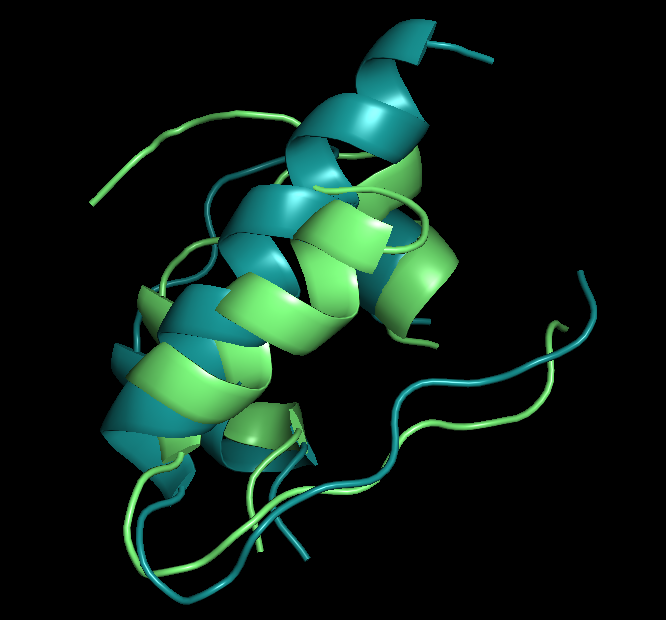

In [12]:
display(Image('img/pymol_view_aligned1.png'))

## 5. Interface for running on arbitrary structures
(the code cell in "3. Implementation" section must be run before)

Takes relative paths to two `.pdb`. 

Saves aligned structures under the same path, but with suffix `aligned` appended to filename.

In [14]:
f1 = input('path to the first .pdb:')
f2 = input('path to the second .pdb:')
# or you can manually set variable names for f1 and f2:
# f1 = "1lph_1m_woP.pdb"
# f2 = "1zeh_1m_woP.pdb"

files = [f1, f2]
s1, s2 = Kabsch(files, debug=False)

io = PDBIO()
for s in [s1, s2]:
    file = s.get_id() + '_aligned.pdb'
    io.set_structure(s)
    io.save(file)